# Line Segmentation in Historical Document

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Document Image Preprocessing

### Data Loading and Exploration

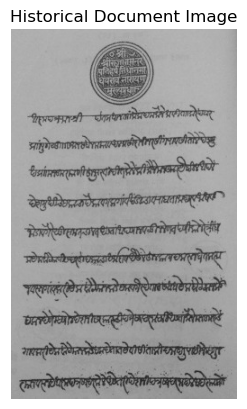

In [4]:
def load_document_image():
    img = cv2.imread('images/historical-doc.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # covnert to RGB
    return img

img = load_document_image()
plt.imshow(img)
plt.axis('off')
plt.title("Historical Document Image")
plt.show()

In [5]:
# print basic image information
print("Image Height:", img.shape[0])
print("Image Width:", img.shape[1])
print("Number of Channels:", img.shape[2])
print("Pixel Value Range:", np.min(img),'to', np.max(img))
print("Data Type:", img.dtype)

Image Height: 411
Image Width: 251
Number of Channels: 3
Pixel Value Range: 28 to 190
Data Type: uint8


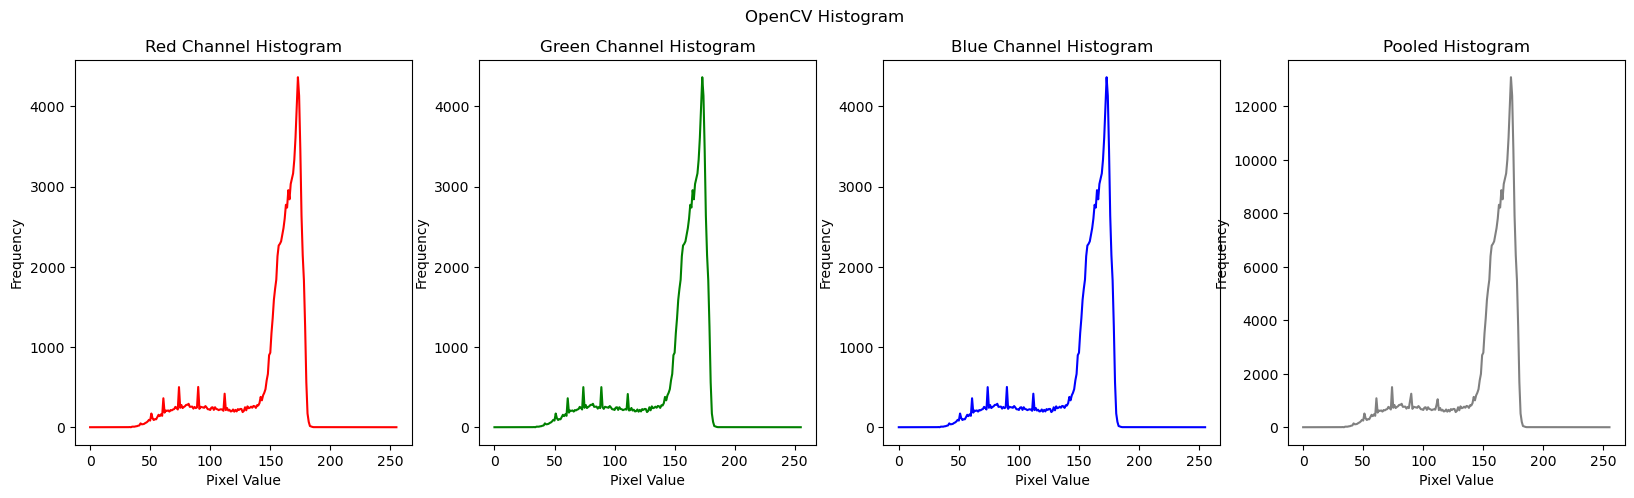

In [6]:
def plot_histogram(r, g, b, pooled, title):
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    
    ax[0].plot(range(256), r, color='red')
    ax[0].set_title("Red Channel Histogram")
    ax[0].set_xlabel("Pixel Value")
    ax[0].set_ylabel("Frequency")
    ax[1].plot(range(256), g, color='green')
    ax[1].set_title("Green Channel Histogram")
    ax[1].set_xlabel("Pixel Value")
    ax[1].set_ylabel("Frequency")
    ax[2].plot(range(256), b, color='blue')
    ax[2].set_title("Blue Channel Histogram")
    ax[2].set_xlabel("Pixel Value")
    ax[2].set_ylabel("Frequency")
    ax[3].plot(range(256), pooled, color='gray')
    ax[3].set_title("Pooled Histogram")
    ax[3].set_xlabel("Pixel Value")
    ax[3].set_ylabel("Frequency")
    
    plt.suptitle(title)
    plt.show()

# opencv histogram
r_hist = cv2.calcHist([img], [0], None, [256], [0, 256])
g_hist = cv2.calcHist([img], [1], None, [256], [0, 256])
b_hist = cv2.calcHist([img], [2], None, [256], [0, 256])
pooled_hist = r_hist + g_hist + b_hist
plot_histogram(r_hist, g_hist, b_hist, pooled_hist, "OpenCV Histogram")

### Image Preprocessing for Text Line Detection

In [82]:
def preprocess_image(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_blur = cv2.GaussianBlur(img_gray, (3, 3), 0)
    img_binary = cv2.threshold(img_blur, 130, 255, cv2.THRESH_BINARY)[1]
    img_inversed = cv2.bitwise_not(img_binary)
    img_dialated = cv2.dilate(img_inversed, np.ones((1,3)), iterations=3)
    return img_dialated

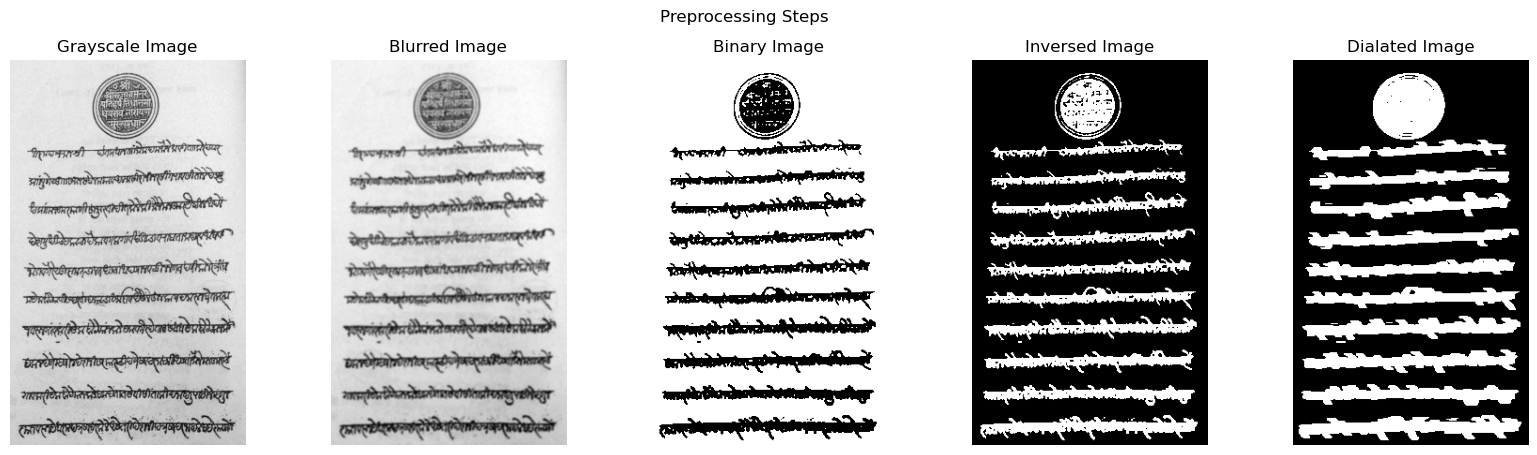

In [ ]:
# intermediate steps in preprocessing
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (3, 3), 0)
img_binary = cv2.threshold(img_blur, 130, 255, cv2.THRESH_BINARY)[1]
img_inversed = cv2.bitwise_not(img_binary)
img_dialated = cv2.dilate(img_inversed, np.ones((1,3)), iterations=3)

ax[0].imshow(img_gray, cmap='gray')
ax[0].axis('off')
ax[0].set_title("Grayscale Image")
ax[1].imshow(img_blur, cmap='gray')
ax[1].axis('off')
ax[1].set_title("Blurred Image")
ax[2].imshow(img_binary, cmap='gray')
ax[2].axis('off')
ax[2].set_title("Binary Image")
ax[3].imshow(img_inversed, cmap='gray')
ax[3].axis('off')
ax[3].set_title("Inversed Image")
ax[4].imshow(img_dialated, cmap='gray')
ax[4].axis('off')
ax[4].set_title("Dialated Image")
plt.suptitle("Preprocessing Steps")
plt.show()


#### Preprocessing Steps
- ****Grayscale Conversion****: Converted to image to grayscale as color information is not required for text line detection but rather based on the structural and spatial arrangement of the text.
- ****Gaussian Blurring****: Applied Gaussian blur to the grayscale image to reduce noise and detail. Parameters used are kernel size of 3x3 and sigma value of 0 to ensure that the text information is not lost while removing noise.
- ****Binary Thresholding****: Applied binary thresholding to convert the image to binary image. This reduces the image to only a foreground and background. The threshold value is chosen as 130 based on the text intensity distribution in the grayscale image.
- ****Inversion****: Inverted the binary image to make the text lines as foreground and page as background. This is necessary for the subsequent morphological operations as they are designed to work on the foreground pixels.
- ****Dilaiton****: Applied dialation with a horizontal kernel to connect the text characters and create a single connected component. The kernel size is chosen as 3x10 to ensure that the text lines are connected horizontally without merging the text lines.

## Text Line Detection and Segmentation

### Rectangular Bounding Box Detection

In [260]:
# function to detect lines with bounding boxes
def detect_lines_with_bboxes(img, padding, height_thresh):
    # find contours
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # get bounding boxes for each contour
    bboxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if h > height_thresh: # ignore small boxes
            bboxes.append((x-padding, y-padding, x+w+padding, y+h+padding))
        
    return bboxes

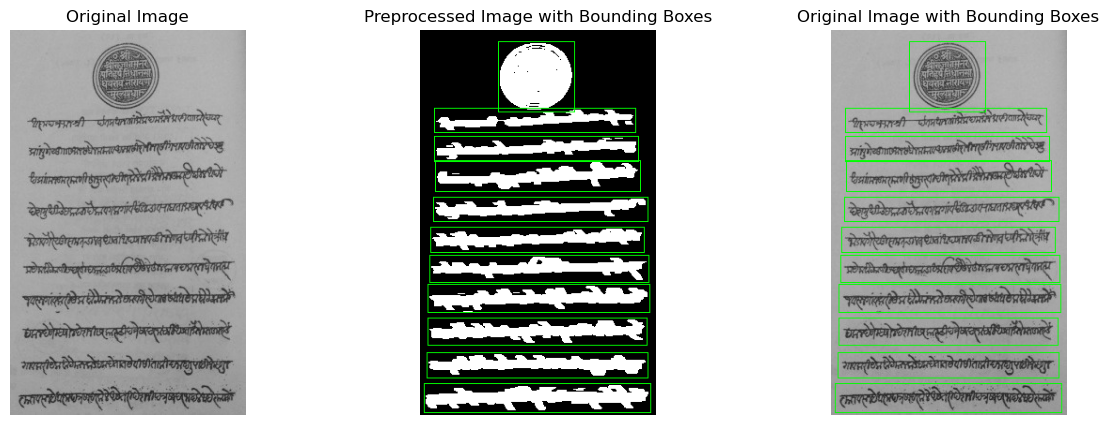

In [267]:
preprocessed_img = preprocess_image(img)
preprocessed_img_copy = cv2.cvtColor(preprocessed_img.copy(), cv2.COLOR_GRAY2RGB)
bboxes = detect_lines_with_bboxes(preprocessed_img, padding=2, height_thresh=10)
img_with_bboxes = img.copy()
for bbox in bboxes:
    cv2.rectangle(img_with_bboxes, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 1)
    cv2.rectangle(preprocessed_img_copy, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0,255,0), 1)
    
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img, cmap='gray')
ax[0].axis('off')
ax[0].set_title("Original Image")
ax[1].imshow(preprocessed_img_copy, cmap='gray')
ax[1].axis('off')
ax[1].set_title("Preprocessed Image with Bounding Boxes")
ax[2].imshow(img_with_bboxes, cmap='gray')
ax[2].axis('off')
ax[2].set_title("Original Image with Bounding Boxes")
plt.show()


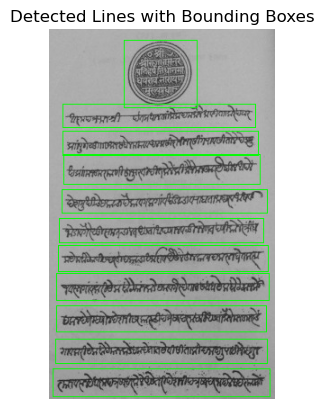

In [268]:
plt.imshow(img_with_bboxes)
plt.axis('off')
plt.title("Detected Lines with Bounding Boxes")
plt.show()

In [270]:
# saving each cropped line as a separate image
bboxes = sorted(bboxes, key=lambda x: x[1])
for i, bbox in enumerate(bboxes):
    x1, y1, x2, y2 = bbox
    line_img = img[y1:y2, x1:x2]
    cv2.imwrite(f'outputs/line_{i+1}.png', cv2.cvtColor(line_img, cv2.COLOR_RGB2BGR))

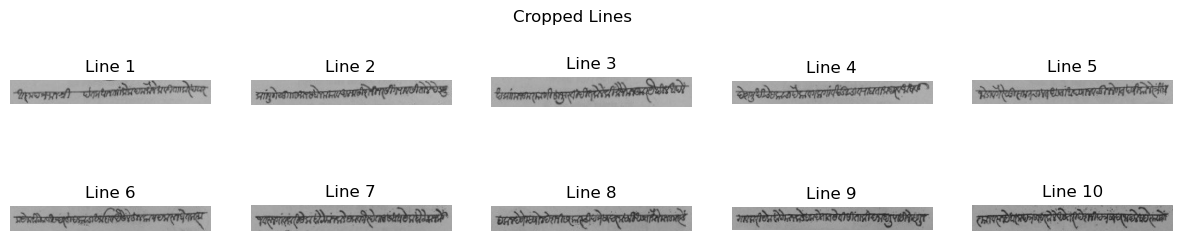

In [274]:
# show the saved lines in a grid
fig, ax = plt.subplots(2, 5, figsize=(15, 3))
for i in range(10):
    img = cv2.imread(f'outputs/line_{i+2}.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title(f"Line {i+1}")
plt.suptitle("Cropped Lines")
plt.show()

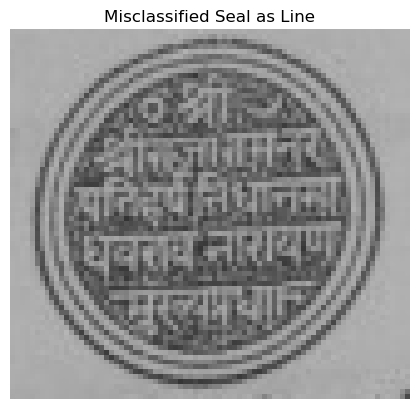

In [276]:
# misclassified line
line_1 = cv2.imread('outputs/line_1.png')
line_1 = cv2.cvtColor(line_1, cv2.COLOR_BGR2RGB)
plt.imshow(line_1)
plt.axis('off')
plt.title("Misclassified Seal as Line")
plt.show()

#### Performane of the algorithm
- The algorithm is able to detect the text lines in the historical document image with good visual quality.
- As the image has uniform text size and spacing with no curved text, the algorithm works well in detecting the text lines as we are using horizontal dilation to connect the text characters.

#### Failure Cases
- The algorithm may fail in detecting the text lines in the presence of curved text or non-uniform text size and spacing.
- The algorithm may also fail in detecting the text lines if the text lines are not horizontal or have large gaps between the text lines.
- The algorithm may also fail in detecting the text lines if the text lines are not connected horizontally.
- The algorithm may also fail in cases where the document has complex layout with multiple columns or text blocks along with images.

One evident failure in the current case, is the detection of the entire seal as a text line. 


### Line Segmentation within the Circular Region

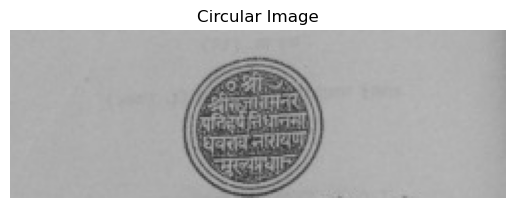

In [279]:
# segment main image to get circular seal
img = load_document_image()
circular_img = img[:85, :]
plt.imshow(circular_img)
plt.axis('off')
plt.title("Circular Image")
plt.show()

In [293]:
def preprocess_image_seal(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_blur = cv2.GaussianBlur(img_gray, (5, 5), 1)
    img_binary = cv2.threshold(img_blur, 128, 255, cv2.THRESH_BINARY)[1]
    circles = cv2.HoughCircles(img_binary, cv2.HOUGH_GRADIENT, 1, 1, param1=40, param2=30, minRadius=25, maxRadius=35)
    circles = np.uint16(np.around(circles))
    circle = circles[0][0]
    mask = np.zeros_like(img_gray)
    cv2.circle(mask, (circle[0], circle[1]), circle[2]-2, (255, 255, 255), -1)
    img_focussed = cv2.bitwise_and(img_gray, mask)
    img_focussed = np.where(img_focussed < 140, 0, img_focussed)
    img_dialated = cv2.dilate(img_focussed, np.ones((1,3)), iterations=5)
    img_eroded = cv2.erode(img_dialated, np.ones((1,3)), iterations=6)
    return img_eroded

In [ ]:
# intermediate steps in preprocessing
c_img_gray = cv2.cvtColor(circular_img, cv2.COLOR_RGB2GRAY)
# apply gaussian blur to reduce noise
c_img_blur = cv2.GaussianBlur(c_img_gray, (5, 5), 1)

# use hough circle transform to detect the seal circle
c_img_binary = cv2.threshold(c_img_blur, 128, 255, cv2.THRESH_BINARY)[1]
circles = cv2.HoughCircles(c_img_binary, cv2.HOUGH_GRADIENT, 1, 1, param1=40, param2=30, minRadius=25, maxRadius=35)
circles = np.uint16(np.around(circles))
circle = circles[0][0]
c_img_gray_with_circle = cv2.cvtColor(c_img_gray.copy(), cv2.COLOR_GRAY2RGB)
cv2.circle(c_img_gray_with_circle, (circle[0], circle[1]), circle[2], (0, 255, 0), 2)

# create and apply background mask
c_mask = np.zeros_like(c_img_gray)
cv2.circle(c_mask, (circle[0], circle[1]), circle[2]-2, (255, 255, 255), -1)
c_focussed = np.bitwise_and(c_img_gray, c_mask)
c_focussed = np.where(c_focussed < 140, 0, c_focussed)

# dilated image to connect characters
c_img_dilated = cv2.dilate(c_focussed, np.ones((1,3)), iterations=5)
# erode to separate lines
c_img_eroded = cv2.erode(c_img_dilated, np.ones((1,3)), iterations=6)

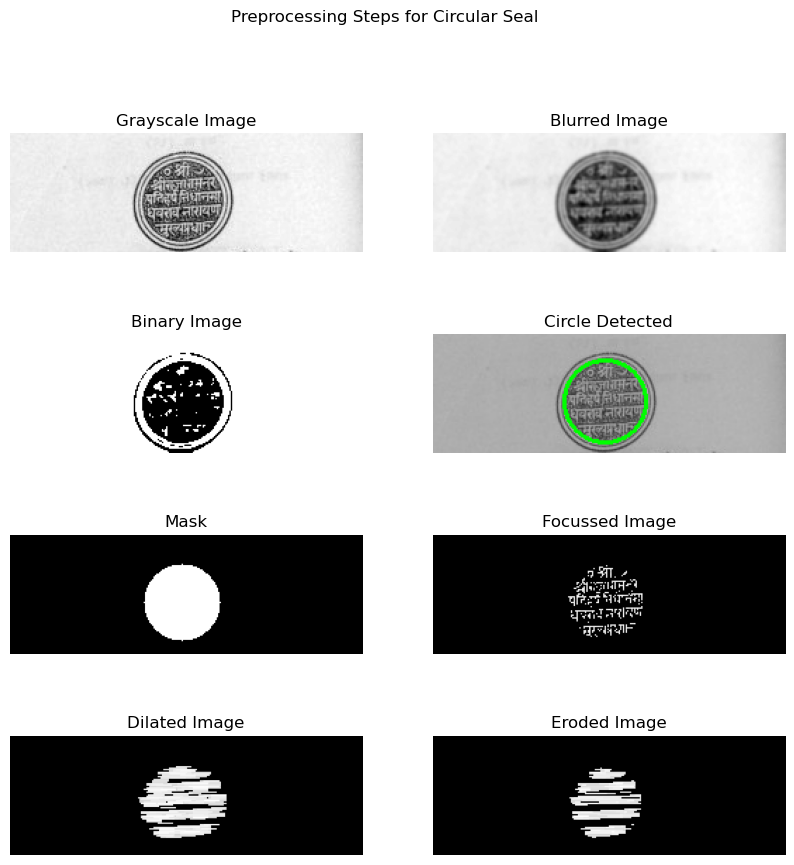

In [286]:
# plot c_gray, c_img_blur, c_img_binary, c_img_gray_with_circle, c_mask, c_focussed, c_img_dilated, c_img_eroded in a 4x2 grid
fig, ax = plt.subplots(4, 2, figsize=(10, 10))
ax[0, 0].imshow(c_img_gray, cmap='gray')
ax[0, 0].axis('off')
ax[0, 0].set_title("Grayscale Image")
ax[0, 1].imshow(c_img_blur, cmap='gray')
ax[0, 1].axis('off')
ax[0, 1].set_title("Blurred Image")
ax[1, 0].imshow(c_img_binary, cmap='gray')
ax[1, 0].axis('off')
ax[1, 0].set_title("Binary Image")
ax[1, 1].imshow(c_img_gray_with_circle, cmap='gray')
ax[1, 1].axis('off')
ax[1, 1].set_title("Circle Detected")
ax[2, 0].imshow(c_mask, cmap='gray')
ax[2, 0].axis('off')
ax[2, 0].set_title("Mask")
ax[2, 1].imshow(c_focussed, cmap='gray')
ax[2, 1].axis('off')
ax[2, 1].set_title("Focussed Image")
ax[3, 0].imshow(c_img_dilated, cmap='gray')
ax[3, 0].axis('off')
ax[3, 0].set_title("Dilated Image")
ax[3, 1].imshow(c_img_eroded, cmap='gray')
ax[3, 1].axis('off')
ax[3, 1].set_title("Eroded Image")
plt.suptitle("Preprocessing Steps for Circular Seal")
plt.show()


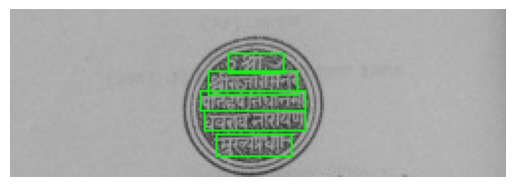

In [296]:
# text segmentation in circular seal
preprocessed_img = preprocess_image_seal(circular_img)
bboxes_seal = detect_lines_with_bboxes(preprocessed_img, padding=1, height_thresh=5)

circular_img_with_bboxes = circular_img.copy()
for bbox in bboxes_seal:
    cv2.rectangle(circular_img_with_bboxes, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 1)
    
plt.imshow(circular_img_with_bboxes)
plt.axis('off')
plt.show()

In [297]:
# saving each cropped line as a separate image
bboxes_seal = sorted(bboxes_seal, key=lambda x: x[1])
for i, bbox in enumerate(bboxes_seal):
    x1, y1, x2, y2 = bbox
    line_img = circular_img[y1:y2, x1:x2]
    cv2.imwrite(f'outputs/circle_line_{i+1}.png', cv2.cvtColor(line_img, cv2.COLOR_RGB2BGR))
    

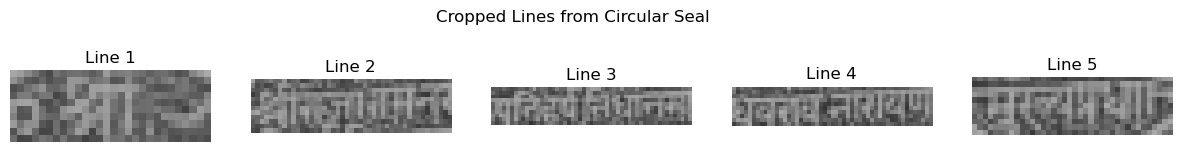

In [300]:
# show the saved lines in a 1x5 grid
fig, ax = plt.subplots(1, 5, figsize=(15, 2))
for i in range(5):
    img = cv2.imread(f'outputs/circle_line_{i+1}.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(f"Line {i+1}")
plt.suptitle("Cropped Lines from Circular Seal")
plt.show()

#### Challenges in Line Segmentation within Seal
- The seal region has the text in a different color than the text in the main document. This makes it difficult to segment the text lines within the seal region using the same thresholding and dilation operations.
- A separate set of preprocessing steps and parameters have been used to segment the text lines within the seal region.
- The text color in the seal region is similar to the background color in the main document. This required finding the seal using Hough Circle Transform and changing the background color to black to segment the text lines within the seal region.
- Erosion and dialation operations are used to segment the text lines within the seal region using a horizontal structuring element.

### Line Segmentation on the entire document

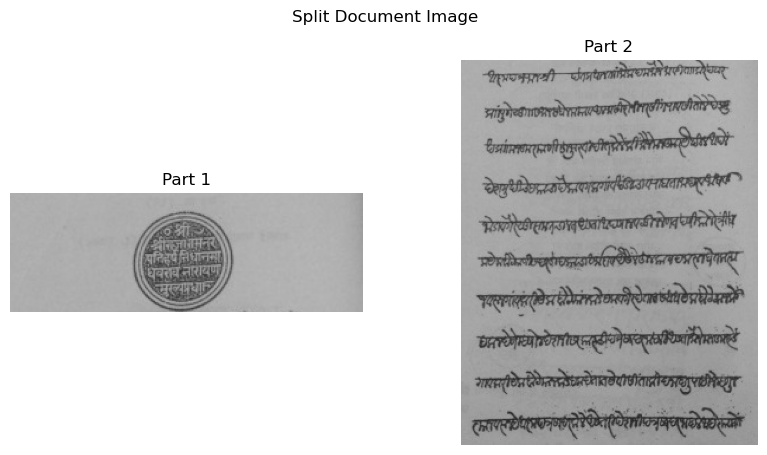

In [301]:
# split document image into two parts
img = load_document_image()
part1 = img[:85, :]
part2 = img[85:, :]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(part1)
ax[0].axis('off')
ax[0].set_title("Part 1")
ax[1].imshow(part2)
ax[1].axis('off')
ax[1].set_title("Part 2")
plt.suptitle("Split Document Image")
plt.show()

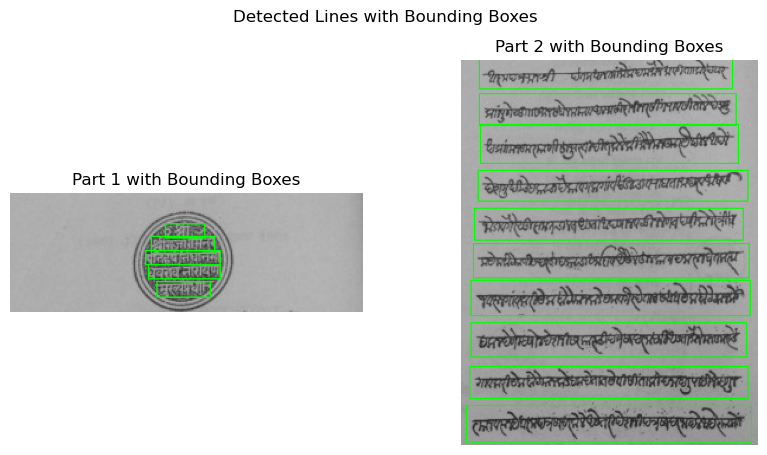

In [302]:
# detect bounding boxes in part 1
preprocessed_img_1 = preprocess_image_seal(part1)
bboxes_1 = detect_lines_with_bboxes(preprocessed_img_1, padding=1, height_thresh=5)
part1_with_bboxes = part1.copy()
for bbox in bboxes_1:
    cv2.rectangle(part1_with_bboxes, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 1)
    
# detect bounding boxes in part 2
preprocessed_img_2 = preprocess_image(part2)
bboxes_2 = detect_lines_with_bboxes(preprocessed_img_2, padding=2, height_thresh=10)
part2_with_bboxes = part2.copy()
for bbox in bboxes_2:
    cv2.rectangle(part2_with_bboxes, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 1)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(part1_with_bboxes)
ax[0].axis('off')
ax[0].set_title("Part 1 with Bounding Boxes")
ax[1].imshow(part2_with_bboxes)
ax[1].axis('off')
ax[1].set_title("Part 2 with Bounding Boxes")
plt.suptitle("Detected Lines with Bounding Boxes")
plt.show()

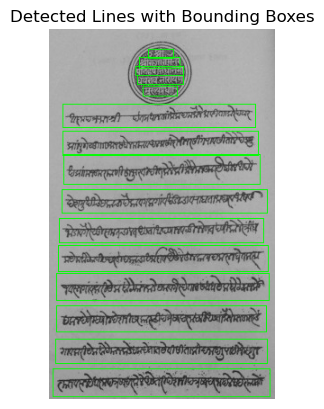

In [320]:
# draw all bounding boxes in the main image
img_with_bboxes = img.copy()
for bbox in bboxes_1:
    cv2.rectangle(img_with_bboxes, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 1)
for bbox in bboxes_2:
    cv2.rectangle(img_with_bboxes, (bbox[0], bbox[1]+85), (bbox[2], bbox[3]+85), (0, 255, 0), 1)

plt.imshow(img_with_bboxes)
plt.axis('off')
plt.title("Detected Lines with Bounding Boxes")
plt.show()

## Tighter Polygonal Boundary Detection

In [323]:
def detect_lines_with_polygons(img, padding, height_thresh):
    # find contours
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # get bounding boxes for each contour
    polygons = []
    for contour in contours:
        epsilon = 0.001 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        x, y, w, h = cv2.boundingRect(approx)
        if h > height_thresh: # ignore small boxes
            polygons.append(approx)
        
    return polygons


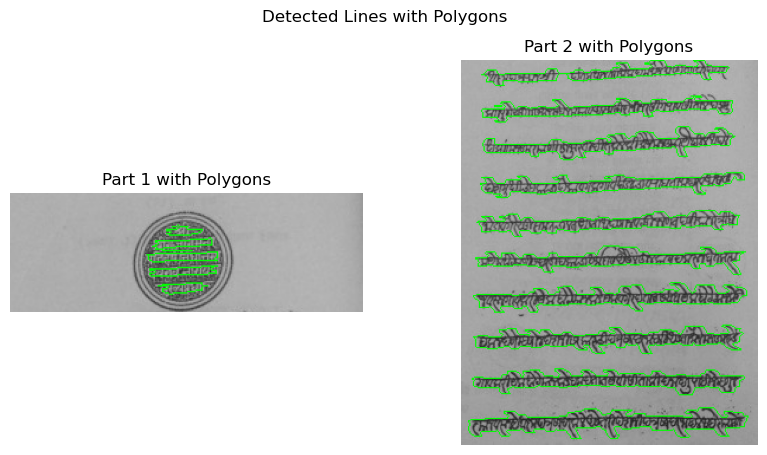

In [324]:
# detect bounding boxes in part 1
preprocessed_img_1 = preprocess_image_seal(part1)
polygons_1 = detect_lines_with_polygons(preprocessed_img_1, padding=1, height_thresh=5)
part1_with_polygons = part1.copy()
for polygon in polygons_1:
    cv2.drawContours(part1_with_polygons, [polygon], 0, (0, 255, 0), 1)
    
# detect bounding boxes in part 2
preprocessed_img_2 = preprocess_image(part2)
polygons_2 = detect_lines_with_polygons(preprocessed_img_2, padding=2, height_thresh=10)
part2_with_polygons = part2.copy()
for polygon in polygons_2:
    cv2.drawContours(part2_with_polygons, [polygon], 0, (0, 255, 0), 1)
    
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(part1_with_polygons)
ax[0].axis('off')
ax[0].set_title("Part 1 with Polygons")
ax[1].imshow(part2_with_polygons)
ax[1].axis('off')
ax[1].set_title("Part 2 with Polygons")
plt.suptitle("Detected Lines with Polygons")
plt.show()

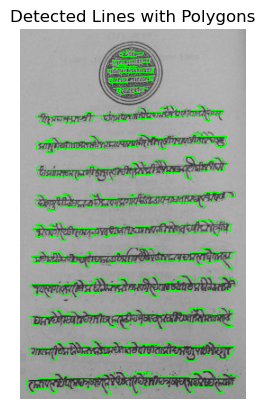

In [325]:
# draw all bounding boxes in the main image
img_with_polygons = img.copy()
for polygon in polygons_1:
    cv2.drawContours(img_with_polygons, [polygon], 0, (0, 255, 0), 1)
for polygon in polygons_2:
    polygon = polygon + np.array([0, 85])
    cv2.drawContours(img_with_polygons, [polygon], 0, (0, 255, 0), 1)
    
plt.imshow(img_with_polygons)
plt.axis('off')
plt.title("Detected Lines with Polygons")
plt.show()

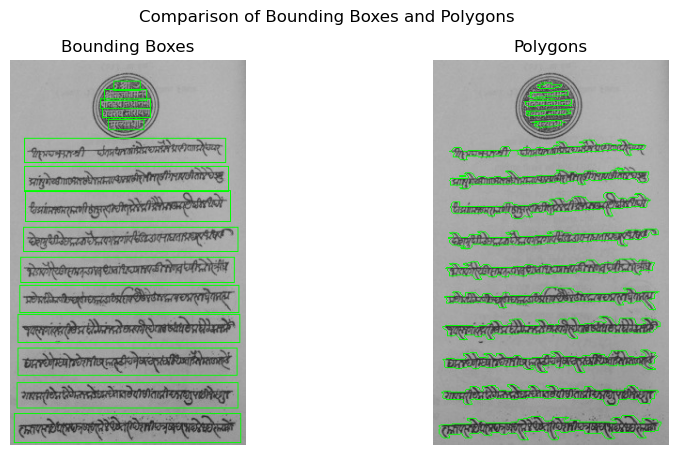

In [322]:
# Comparison of Bounding Boxes and Polygons
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_with_bboxes)
ax[0].axis('off')
ax[0].set_title("Bounding Boxes")
ax[1].imshow(img_with_polygons)
ax[1].axis('off')
ax[1].set_title("Polygons")
plt.suptitle("Comparison of Bounding Boxes and Polygons")
plt.show()

#### Advantages of Tighter Polygonal Boundary Detection
- The tighter polygonal boundary detection helps in detecting the text lines more accurately by removing the extra white space around the text lines.
- Polygons can better adapt to skewed text lines and curved text lines compared to rectangular bounding boxes.

#### Disadvantages of Tighter Polygonal Boundary Detection
- It is computationally expensive compared to rectangular bounding box detection. Since it stores multiple points for each polygon, it requires more memory and processing time.
- If the document is not properly processed, the algorithm will be sensitive to noise and may not detect the text lines accurately.
- It may not work well for overlapping or intersecting text lines as it may create a single polygon for multiple text lines.
- For the seal region, the polygonal boundary detection is not great as the text erosion leads to some loss of text information.